# Soil Moisture:
Soil Moisture in its simplest form is the water stored in the soil. This parameter is affected by the temperature of the region, the total precipitation of the region, and also the characteristics of the soil as well as the moisture holding capacity of the soil.

## Getting the dataset:
The dataset for this EDA has been accessed from https://gimms.gsfc.nasa.gov which has the soil moisture data from the year 02/04/2015 till 18/07/2020. The data is available in GRIB format and is recorded every three days. The spatial resolution of the data is 0.25 x 0.25 degrees. The dataset is available publicly.

In [4]:
!mkdir data
%cd data

/content/data


In [5]:
import requests
import bs4
path = 'https://gimms.gsfc.nasa.gov/SMOS/SMAP/L03/'
r = requests.get(path)
soup = bs4.BeautifulSoup(r.text, 'html.parser')

links = soup.find_all('a')
print("Found total {} links".format(len(links)))

Found total 1295 links


In [6]:
import sys
print("Downloading data.....")
l = len(links)
for i,link in enumerate(links):
  sys.stdout.write('\r{:.2f} % complete          '.format(i/l*100))
  if link['href'].endswith('.as1.grib'):
    file_ = requests.get(path+link['href'])
    with open(link['href'], 'wb') as f:
      f.write(file_.content)
  else:
    pass
sys.stdout.write('\r100 % complete       \n')
print("Done")
%cd /content

100 % complete       
Done


## Starting with the EDA:

In [7]:
import pygrib
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
%matplotlib inline

In [9]:
grbs = pygrib.open('data/20150402_20150404.as1.grib')

/content


In [10]:
grb_1 = grbs.select()[0]
grb_1.values.shape

(600, 1440)

In [11]:
print(len(grb_1.keys()))
print(grb_1.keys())

176
['globalDomain', 'GRIBEditionNumber', 'eps', 'offsetSection0', 'section0Length', 'totalLength', 'editionNumber', 'WMO', 'productionStatusOfProcessedData', 'section1Length', 'wrongPadding', 'table2Version', 'centre', 'centreDescription', 'generatingProcessIdentifier', 'gridDefinition', 'indicatorOfParameter', 'parameterName', 'parameterUnits', 'indicatorOfTypeOfLevel', 'pressureUnits', 'typeOfLevelECMF', 'typeOfLevel', 'level', 'yearOfCentury', 'month', 'day', 'hour', 'minute', 'second', 'unitOfTimeRange', 'P1', 'P2', 'timeRangeIndicator', 'numberIncludedInAverage', 'numberMissingFromAveragesOrAccumulations', 'centuryOfReferenceTimeOfData', 'subCentre', 'paramIdECMF', 'paramId', 'cfNameECMF', 'cfName', 'cfVarNameECMF', 'cfVarName', 'unitsECMF', 'units', 'nameECMF', 'name', 'decimalScaleFactor', 'setLocalDefinition', 'optimizeScaleFactor', 'dataDate', 'year', 'dataTime', 'julianDay', 'stepUnits', 'stepType', 'stepRange', 'startStep', 'endStep', 'marsParam', 'validityDate', 'validityT

In [12]:
len(grbs.select())

1

In [13]:
# Finding the number of missing values
print('Number of missing values: {}'.format(grb_1['numberOfMissing']))
# Value used instead of missing numbers
print('Value used in place of missing value: {}'.format(grb_1['missingValue']))

Number of missing values: 680775
Value used in place of missing value: 9999


In [14]:
grb_0 = grbs.select()[0]
print("Name of the parameter: {}".format(grb_0['name']))
print("Maximum Value: {}".format(grb_0['maximum']))
print("Minimum Value: {}".format(grb_0['minimum']))
print("Average Value: {}".format(grb_0['average']))
print("Standard Deviation Value: {}".format(grb_0['standardDeviation']))
print("Date (d/M/Y): {}/{}/{}".format(grb_0['day'],grb_0['month'],grb_0['yearOfCentury']))

Name of the parameter: unknown
Maximum Value: 25.400115200000005
Minimum Value: 0.0
Average Value: 13.486237524703515
Standard Deviation Value: 9.069189779525063
Date (d/M/Y): 2/4/15


## Plotting the data:

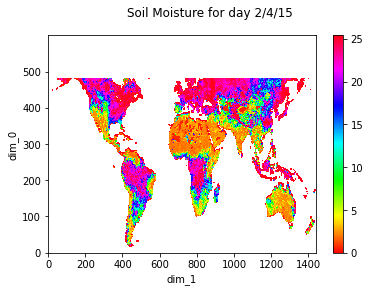

In [16]:
data = xr.DataArray(grb_0.values)
plt.figure().suptitle('Soil Moisture for day 2/4/15', ha='center')
data.plot(cmap='hsv')

## Plotting the statistics of the daily data:

In [18]:
import os
dates = []
means = []
mins = []
maxs = []
vars = []
errors = 0
print("Calculating statistics....")
l = os.listdir('data')
length = len(l)
for i, file_ in enumerate(l):
  sys.stdout.write('\r {:.2f} % complete    '.format(i/length*100))
  try:
    grb = pygrib.open('data/'+file_).select()[0]
    dates.append(str(grb['day'])+'-'+str(grb['month'])+'-'+str(grb['yearOfCentury']))
    means.append(grb['average'])
    mins.append(grb['minimum'])
    maxs.append(grb['maximum'])
    vars.append(grb['standardDeviation']**2)
  except ValueError:
    print("Error for file {}".format(file_))
    errors+=1
    pass
print('\r 100 % complete       \n')
print("Done calculating the statistics")
print("Encountered {} errors".format(errors))

Calculating statistics....
 100 % complete       

Done calculating the statistics
Encountered 0 errors


<BarContainer object of 645 artists>

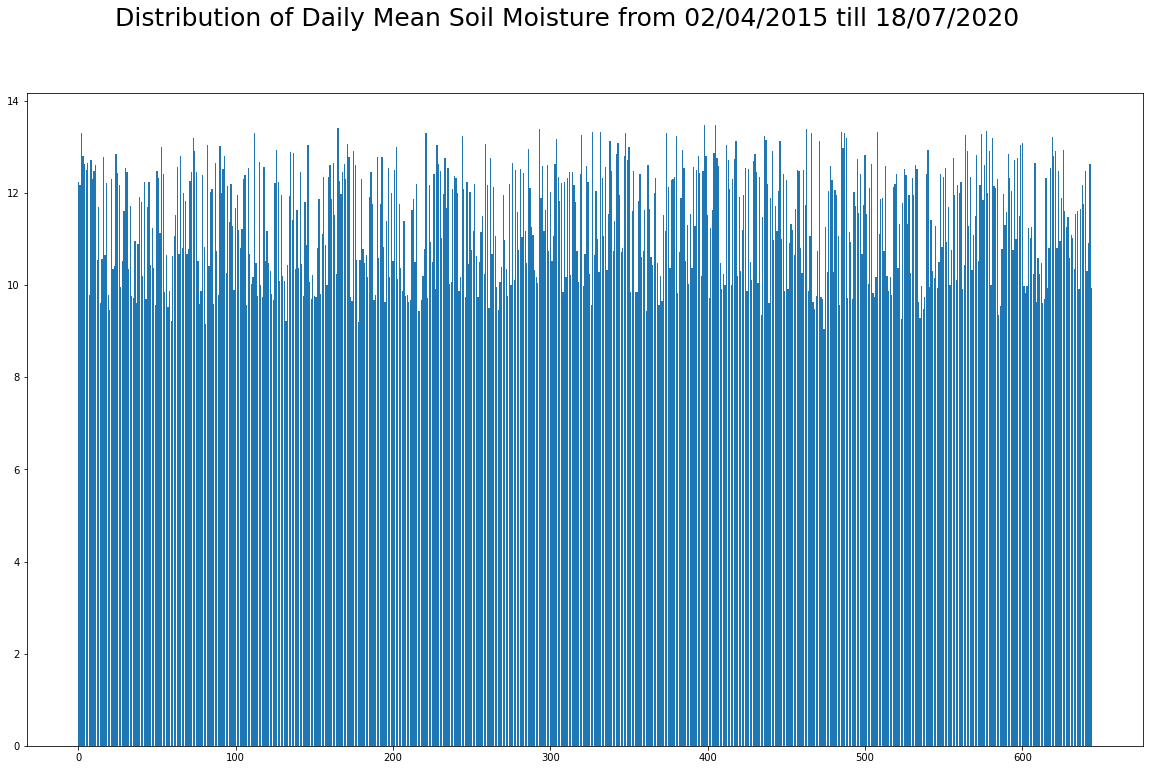

In [19]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Mean Soil Moisture from 02/04/2015 till 18/07/2020', ha='center', fontsize=25)
plt.bar(np.arange(len(means)), means)

<BarContainer object of 645 artists>

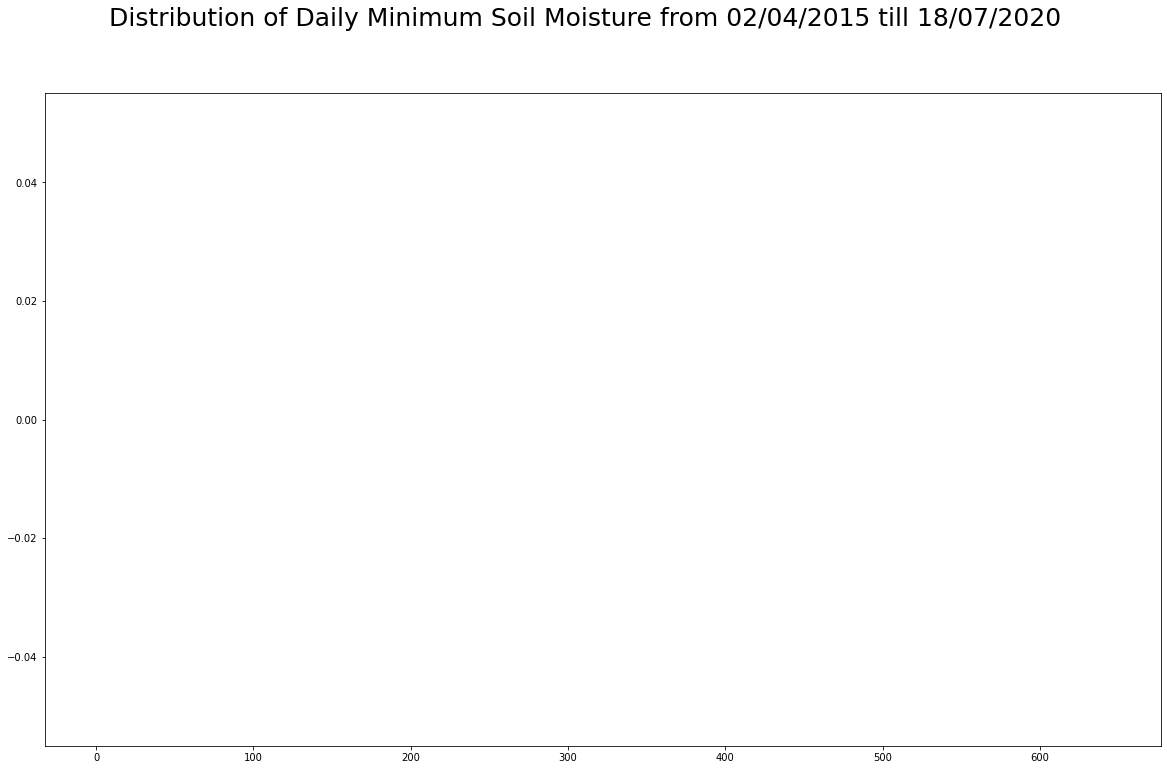

In [20]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Minimum Soil Moisture from 02/04/2015 till 18/07/2020', ha='center', fontsize=25)
plt.bar(np.arange(len(mins)), mins)

<BarContainer object of 645 artists>

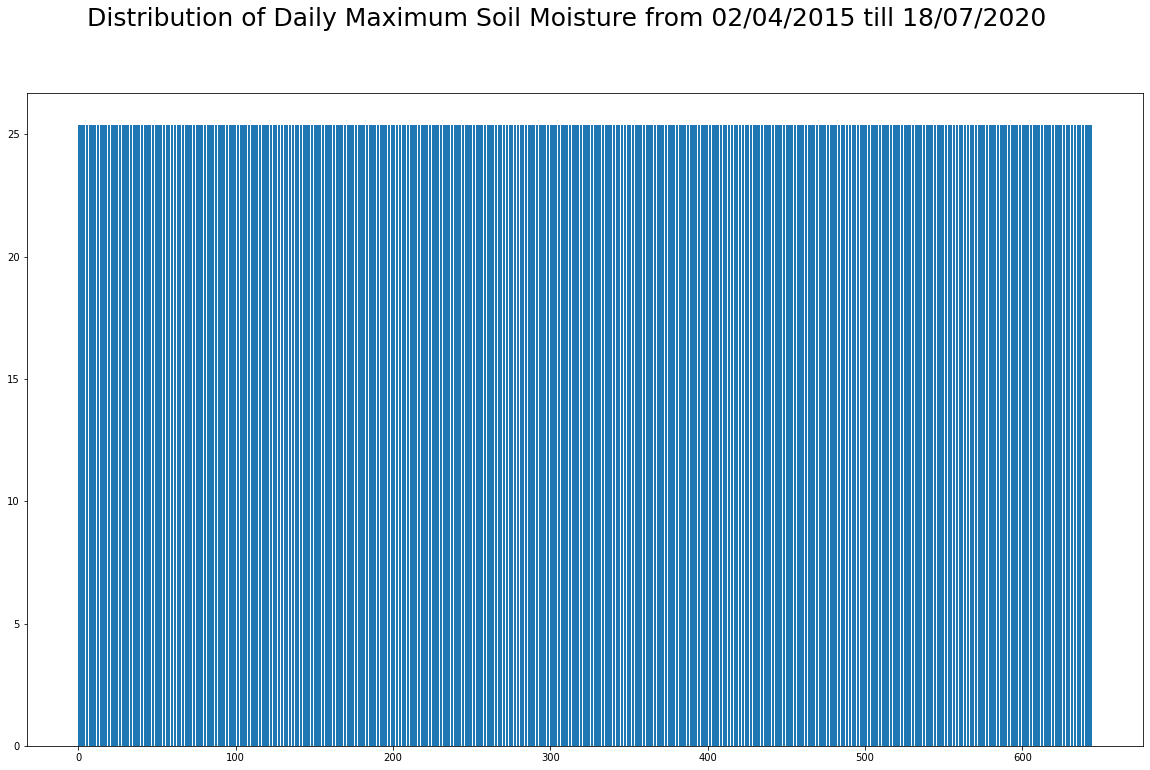

In [21]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Maximum Soil Moisture from 02/04/2015 till 18/07/2020', ha='center', fontsize=25)
plt.bar(np.arange(len(maxs)), maxs)

<BarContainer object of 645 artists>

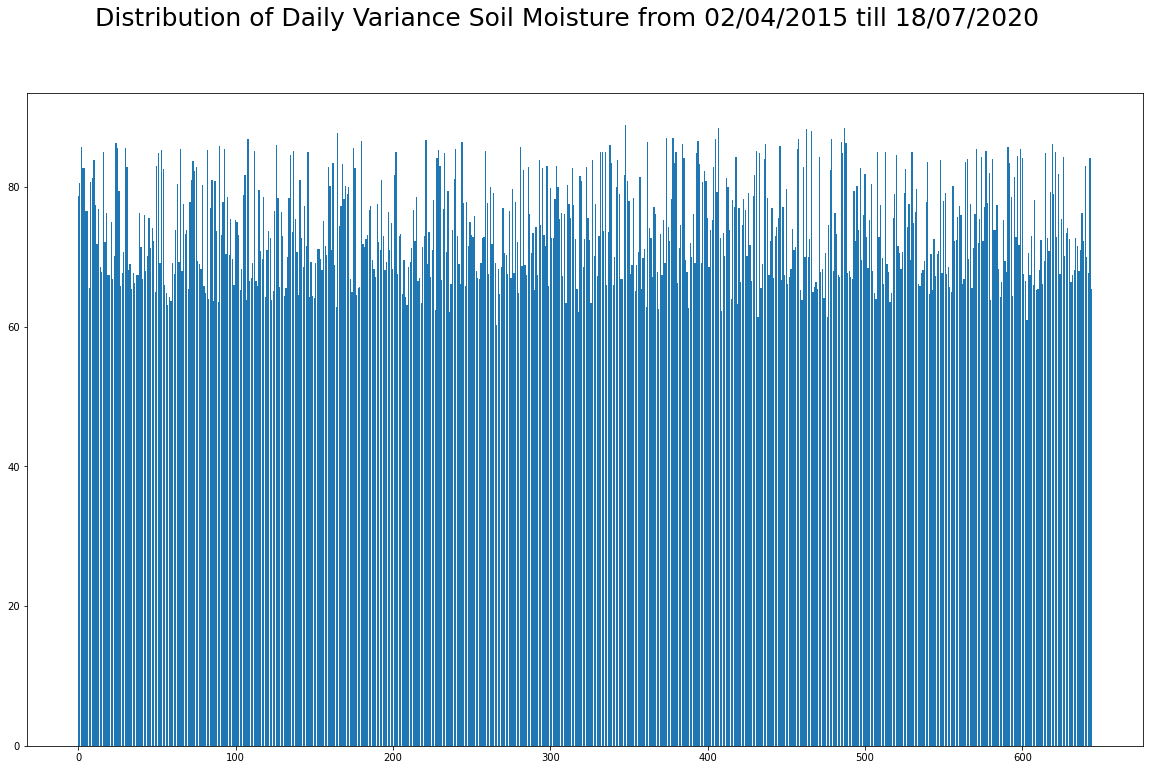

In [23]:
plt.figure(figsize=(20,12)).suptitle('Distribution of Daily Variance Soil Moisture from 02/04/2015 till 18/07/2020', ha='center', fontsize=25)
plt.bar(np.arange(len(vars)), vars)

In [25]:
print("Mean average from 02/04/2015 to 18/07/2020: {}".format(np.array(means).mean()))
print("Mean variance from 02/04/2015 to 18/07/2020: {}".format(np.array(vars).mean()))
print()
print("Variance of average from 02/04/2015 to 18/07/2020: {}".format(np.array(means).var()))
print("Variance of variance from 02/04/2015 to 18/07/2020: {}".format(np.array(vars).var()))

Mean average from 02/04/2015 to 18/07/2020: 11.381658906276265
Mean variance from 02/04/2015 to 18/07/2020: 73.88017472194176

Variance of average from 02/04/2015 to 18/07/2020: 1.3513094139580497
Variance of variance from 02/04/2015 to 18/07/2020: 48.56288351646098


## Summary:
Thus, from the above preliminary EDA of the soil moisture data, it seems that the distribution of the soil moisture around the year is fairly consistent as both the mean and variance distribution has similar shape  


In [27]:
import pandas as pd
data = pd.DataFrame({'Date':dates, 'Mean Soil Moisture': means, 'Minimum Soil Moisture': mins, 'Maximum Soil Moisture':maxs, 'Variance of Soil Moistures': vars})
data.to_csv('Analysis_of_Soil_Moisture.csv', index=False)
data

,Date,Mean Soil Moisture,Minimum Soil Moisture,Maximum Soil Moisture,Variance of Soil Moistures
0,24-3-19,12.233257,0.0,25.400115,78.791382
1,21-3-19,12.180052,0.0,25.400115,80.657108
2,14-2-17,13.301515,0.0,25.400115,85.689184
3,4-4-18,12.811820,0.0,25.400115,82.760178
4,26-2-20,12.635954,0.0,25.400115,82.785379
...,...,...,...,...,...
640,10-1-18,12.479331,0.0,25.400115,83.061175
641,11-10-15,10.304172,0.0,25.400115,69.961599
642,13-6-16,10.918058,0.0,25.400115,67.662142
643,10-2-19,12.642730,0.0,25.400115,84.213695
